In [30]:
import sys 
import paddle
import paddle.nn.functional as F
import os
from tqdm import tqdm
import random
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from IPython import display
import soundfile
from python_speech_features import mfcc, delta # 导入音频特征提取工具包
import scipy.io.wavfile as wav
import wave

这段音频的采样率为：8000
音频信号： [ 12  39 179 ...  83  68 114]
音频信号形状： (4304,)


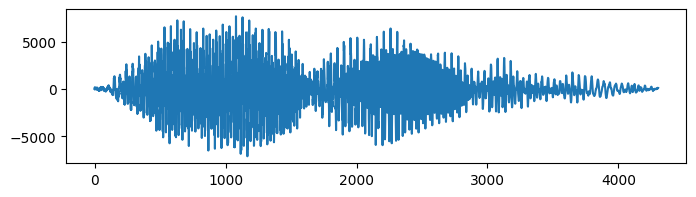

In [7]:
example_path='FSDD/0_george_14.wav'

# 读取音频
# fs--采样率 signal--音频信号
fs, signal = wav.read(example_path)
print('这段音频的采样率为：%d' % fs)
print('音频信号：', signal)
print('音频信号形状：', signal.shape)

# 绘制波形
plt.figure(figsize=(8,2))
x = [_ for _ in range(len(signal))]
plt.plot(x, signal)
plt.show()


In [83]:
obj = wave.open("FSDD/0_george_14.wav","rb")


print('framerate：' ,obj.getframerate())
print('channels：' ,obj.getnchannels())
print('sampwidth：', obj.getsampwidth())
print('frames：', obj.getnframes())
print('parames：', obj.getparams())

t_aduio = obj.getnframes() / obj.getframerate()
print(t_aduio)

frames = obj.readframes(-1)
print(len(frames))

obj.close


framerate： 8000
channels： 1
sampwidth： 2
frames： 4304
parames： _wave_params(nchannels=1, sampwidth=2, framerate=8000, nframes=4304, comptype='NONE', compname='not compressed')
0.538
8608


<bound method Wave_read.close of <wave.Wave_read object at 0x0000029FB401E750>>

0.538


<function matplotlib.pyplot.show(close=None, block=None)>

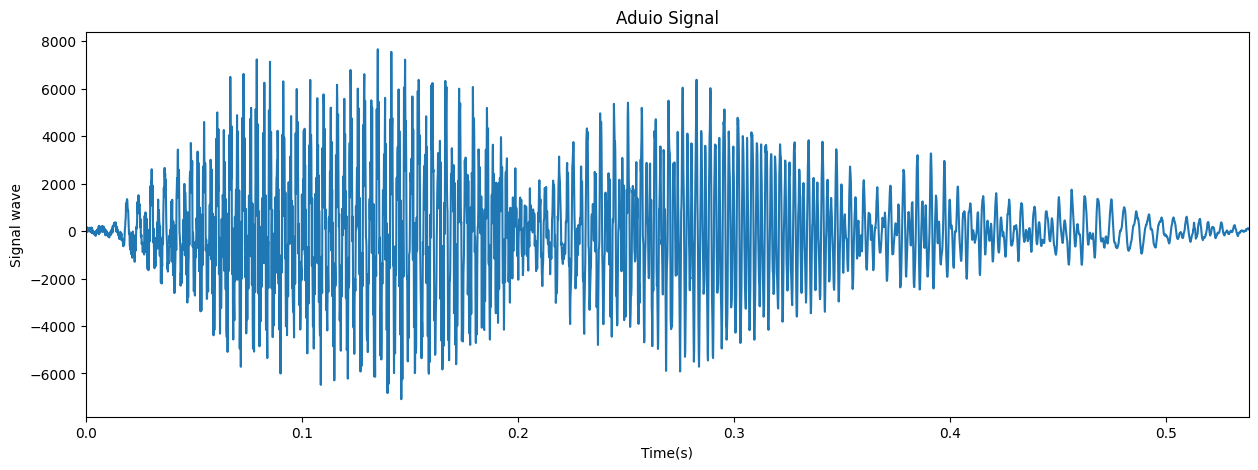

In [9]:
obj = wave.open("FSDD/0_george_14.wav","rb")

sample_freq = obj.getframerate()
n_sample = obj.getnframes()
signal_wave = obj.readframes(-1)

obj.close

t_adu = n_sample / sample_freq
print(t_adu)

signal_array = np.frombuffer(signal_wave,dtype=np.int16)

times = np.linspace(0,t_adu,num=n_sample)

plt.figure(figsize=(15,5))
plt.plot(times,signal_array)
plt.title("Aduio Signal")
plt.ylabel("Signal wave")
plt.xlabel("Time(s)")
plt.xlim(0,t_adu)
plt.show


In [68]:
#获取音频文件名称列表
data_path='FSDD'
wavs = glob("{}/*.wav".format(data_path), recursive=True)
print(type(wavs),wavs[0])

# 打乱音频文件名称列表
random.shuffle(wavs)
wavs_len=len(wavs)
print("总数据数量:\t",wavs_len)


#训练集：验证集：测试集=0.9:0.05:0.05
# 训练集
train_wavs=wavs[:int(wavs_len*0.8)]
# 验证集
val_wavs=wavs[int(wavs_len*0.8):int(wavs_len*0.9)]
# 测试集
test_wavs=wavs[int(wavs_len*0.9):]

print("训练集数目:\t",len(train_wavs),"\n验证集数目:\t",len(val_wavs),"\n测试集数目:\t",len(test_wavs))


<class 'list'> FSDD\0_george_0.wav
总数据数量:	 3000
训练集数目:	 2400 
验证集数目:	 300 
测试集数目:	 300


In [69]:
# MFCC特征提取
def get_mfcc(data, fs):
    # MFCC特征提取
    wav_feature =  mfcc(data, fs)
  
    # 特征一阶差分
    d_mfcc_feat = delta(wav_feature, 1)
    # 特征二阶差分
    d_mfcc_feat2 = delta(wav_feature, 2)
    # 特征拼接
    feature = np.concatenate([wav_feature.reshape(1, -1, 13), d_mfcc_feat.reshape(1, -1, 13), d_mfcc_feat2.reshape(1, -1, 13)], 0)
  
    # 对数据进行截取或者填充
    if feature.shape[1]>64:
        feature = feature[:, :64, :]
    else:
        feature = np.pad(feature, ((0, 0), (0, 64-feature.shape[1]), (0, 0)), 'constant')
    # 通道转置(HWC->CHW)
    feature = feature.transpose((2, 0, 1))
  
    return feature

# 读取音频
fs, signal = wav.read(example_path)
# 特征提取
feature = get_mfcc(signal, fs)
print('特征形状(CHW):', feature.shape,type(feature))


特征形状(CHW): (13, 3, 64) <class 'numpy.ndarray'>


In [70]:
def preproess(wavs):
    datalist=[]
    lablelist=[]
    for w in tqdm(wavs):
        lablelist.append([int(w[5])])
        fs, signal = wav.read(w)
        f = get_mfcc(signal, fs)
        datalist.append(f)
    return np.array(datalist),np.array(lablelist)

train_data,train_lable=preproess(train_wavs)
val_data,val_lable=preproess(val_wavs)
test_data,test_lable=preproess(test_wavs)

#print(type(train_data),train_lable[0])


100%|██████████| 300/300 [00:00<00:00, 688.25it/s]


In [71]:
class MyDataset(paddle.io.Dataset):
    """
    步骤一：继承paddle.io.Dataset类
    """
    def __init__(self,audio,text):
        """
        步骤二：实现构造函数，定义数据集大小
        """
        super(MyDataset, self).__init__()
        self.text = text
        self.audio = audio

    def __getitem__(self, index):
        """
        步骤三：实现__getitem__方法，定义指定index时如何获取数据，并返回单条数据（训练数据，对应的标签）
        """
        return self.audio[index],self.text[index]

    def __len__(self):
        """
        步骤四：实现__len__方法，返回数据集总数目
        """
        return self.audio.shape[0]


In [72]:
def prepare_input(inputs):
    src=np.array([inputsub[0] for inputsub in inputs]).astype('float32')
    trg=np.array([inputsub[1] for inputsub in inputs])
    return src,trg

train_dataset = MyDataset(train_data,train_lable)
train_loader = paddle.io.DataLoader(train_dataset, batch_size=64, shuffle=True,drop_last=True,collate_fn=partial(prepare_input))

val_dataset = MyDataset(val_data,val_lable)
val_loader = paddle.io.DataLoader(val_dataset, batch_size=64, shuffle=True,drop_last=True,collate_fn=partial(prepare_input))


In [73]:
for i,data in enumerate(train_loader):
    for d in data:
        print(d.shape)
    break


[64, 13, 3, 64]
[64, 1]


In [74]:
class audio_Net_1(paddle.nn.Layer):
    def __init__(self):
        super(audio_Net_1, self).__init__()
        self.conv1 = paddle.nn.Conv2D(13, 16, 3, 1, 1)
        self.conv2 = paddle.nn.Conv2D(16, 16, (3, 2), (1, 2), (1, 0))
        self.conv3 = paddle.nn.Conv2D(16, 32, 3, 1, 1)
        self.conv4 = paddle.nn.Conv2D(32, 32, (3, 2), (1, 2), (1, 0))
        self.conv5 = paddle.nn.Conv2D(32, 64, 3, 1, 1)
        self.conv6 = paddle.nn.Conv2D(64, 64, (3, 2), 2)
        self.fc1 = paddle.nn.Linear(512, 128)
        self.fc2 = paddle.nn.Linear(128, 10)
  
  
    # 定义前向网络
    def forward(self, inputs):
        out = self.conv1(inputs)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = self.conv6(out)
        out = paddle.reshape(out, [-1, 8*64])
        out = self.fc1(out)
        out = self.fc2(out)

        return out




In [75]:
class audio_Net_2(paddle.nn.Layer):
    def __init__(self):
        super(audio_Net_2, self).__init__()
        self.conv1 = paddle.nn.Conv2D(13, 16, 3, 1, 1)
        self.conv2 = paddle.nn.Conv2D(16, 32, 3, 1, 1)
        self.pool1 = paddle.nn.MaxPool2D(kernel_size=2, stride=2)  # 池化层1
        self.conv3 = paddle.nn.Conv2D(32, 64, 3, 1, 1)
        self.conv4 = paddle.nn.Conv2D(64, 64, 3, 1, 1)
        self.pool2 = paddle.nn.MaxPool2D(kernel_size=2, stride=2)  # 池化层2
        self.fc1 = paddle.nn.Linear(1024, 128)  # 根据实际输出调整输入特征数量
        self.fc2 = paddle.nn.Linear(128, 10)

    def forward(self, inputs):
        out = F.relu(self.conv1(inputs))
        out = self.pool1(out)  # 应用池化层1
        out = F.relu(self.conv2(out))
        out = F.relu(self.conv3(out))
        out = F.relu(self.conv4(out))
        out = self.pool2(out)  # 应用池化层2
        out = paddle.flatten(out, start_axis=1)  # 展平操作
        out = F.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [76]:
audio_network1 = audio_Net_1()

# 生成随机输入张量，测试模型的正确性
input_tensor = paddle.randn([64, 13, 3, 64], dtype='float32')

# 执行前向传播
output = audio_network1(input_tensor)

# 打印输出结果
print("Model output: ", output.shape)

Model output:  [64, 10]


In [77]:
audio_network2 = audio_Net_2()

# 生成随机输入张量，测试模型的正确性
input_tensor = paddle.randn([64, 13, 3, 64], dtype='float32')

# 执行前向传播
output = audio_network2(input_tensor)

# 打印输出结果
print("Model output: ", output.shape)

Model output:  [64, 10]


In [78]:
epochs = 50 

model=paddle.Model(audio_network1)


model.prepare(optimizer=paddle.optimizer.Adam(learning_rate=0.001,parameters=model.parameters()),
                loss=paddle.nn.CrossEntropyLoss(), 
                metrics=paddle.metric.Accuracy())

model.fit(train_data=train_loader, 
            epochs=epochs,
             eval_data= val_loader
             )


The loss value printed in the log is the current step, and the metric is the average value of previous steps.
Epoch 1/50
step 10/37 - loss: 12.6833 - acc: 0.3625 - 61ms/step
step 20/37 - loss: 7.6045 - acc: 0.5312 - 60ms/step
step 30/37 - loss: 4.3685 - acc: 0.6266 - 60ms/step
step 37/37 - loss: 5.4450 - acc: 0.6639 - 60ms/step
Eval begin...
step 4/4 - loss: 4.4035 - acc: 0.8086 - 25ms/step
Eval samples: 256
Epoch 2/50
step 10/37 - loss: 3.5648 - acc: 0.8906 - 62ms/step
step 20/37 - loss: 3.1824 - acc: 0.8875 - 60ms/step
step 30/37 - loss: 2.0817 - acc: 0.8927 - 60ms/step
step 37/37 - loss: 3.9738 - acc: 0.8953 - 60ms/step
Eval begin...
step 4/4 - loss: 3.7704 - acc: 0.8867 - 21ms/step
Eval samples: 256
Epoch 3/50
step 10/37 - loss: 0.0683 - acc: 0.9563 - 59ms/step
step 20/37 - loss: 0.8815 - acc: 0.9477 - 59ms/step
step 30/37 - loss: 1.5814 - acc: 0.9490 - 59ms/step
step 37/37 - loss: 1.8332 - acc: 0.9455 - 59ms/step
Eval begin...
step 4/4 - loss: 2.5768 - acc: 0.8945 - 21ms/step
Eval

In [86]:
bingo_num=0
for i in range(test_data.shape[0]):
    x=paddle.to_tensor([test_data[i]],dtype='float32')
    out=audio_network1(x)
    out=paddle.nn.functional.softmax(out,axis=-1)
    out=paddle.argmax(out)

    if i<5:
        fs, signal = wav.read(test_wavs[i])
        display.display(display.Audio(signal, rate=fs))
        print("预测值：",out.numpy(),"\t 真实值：",test_lable[i][0])
    if out.numpy()==test_lable[i][0]:
        bingo_num+=1

print("\n准确率（model_1）：",bingo_num/len(test_wavs))

预测值： 7 	 真实值： 7


预测值： 9 	 真实值： 9


预测值： 4 	 真实值： 4


预测值： 0 	 真实值： 0


预测值： 7 	 真实值： 7

准确率（model_1）： 0.8866666666666667


In [89]:
epochs = 50 

model=paddle.Model(audio_network2)


model.prepare(optimizer=paddle.optimizer.Adam(learning_rate=0.001,parameters=model.parameters()),
                loss=paddle.nn.CrossEntropyLoss(), 
                metrics=paddle.metric.Accuracy())

model.fit(train_data=train_loader, 
            epochs=epochs,
             eval_data= val_loader
            #  verbose =2,
            #  log_freq =100,
            #  callbacks=[paddle.callbacks.VisualDL('./log')]
             )

The loss value printed in the log is the current step, and the metric is the average value of previous steps.
Epoch 1/50
step 10/37 - loss: 0.0796 - acc: 0.9922 - 46ms/step
step 20/37 - loss: 0.0321 - acc: 0.9898 - 46ms/step
step 30/37 - loss: 0.0378 - acc: 0.9865 - 46ms/step
step 37/37 - loss: 0.0177 - acc: 0.9869 - 46ms/step
Eval begin...
step 4/4 - loss: 0.1042 - acc: 0.9453 - 18ms/step
Eval samples: 256
Epoch 2/50
step 10/37 - loss: 0.0423 - acc: 0.9891 - 46ms/step
step 20/37 - loss: 0.0082 - acc: 0.9930 - 46ms/step
step 30/37 - loss: 0.0018 - acc: 0.9911 - 46ms/step
step 37/37 - loss: 0.0147 - acc: 0.9916 - 46ms/step
Eval begin...
step 4/4 - loss: 0.0933 - acc: 0.9648 - 17ms/step
Eval samples: 256
Epoch 3/50
step 10/37 - loss: 6.1990e-04 - acc: 0.9969 - 46ms/step
step 20/37 - loss: 0.0015 - acc: 0.9977 - 45ms/step
step 30/37 - loss: 0.0157 - acc: 0.9979 - 46ms/step
step 37/37 - loss: 0.0019 - acc: 0.9979 - 45ms/step
Eval begin...
step 4/4 - loss: 0.1968 - acc: 0.9648 - 18ms/step
E

In [90]:
bingo_num=0
for i in range(test_data.shape[0]):
    x=paddle.to_tensor([test_data[i]],dtype='float32')
    out=audio_network2(x)
    out=paddle.nn.functional.softmax(out,axis=-1)
    out=paddle.argmax(out)

    if i<5:
        fs, signal = wav.read(test_wavs[i])
        display.display(display.Audio(signal, rate=fs))
        print("预测值：",out.numpy(),"\t 真实值：",test_lable[i][0])
    if out.numpy()==test_lable[i][0]:
        bingo_num+=1

print("\n准确率(model_2)：",bingo_num/len(test_wavs))

预测值： 7 	 真实值： 7


预测值： 9 	 真实值： 9


预测值： 4 	 真实值： 4


预测值： 0 	 真实值： 0


预测值： 7 	 真实值： 7

准确率(model_2)： 0.97
